Vòng lặp 1/10


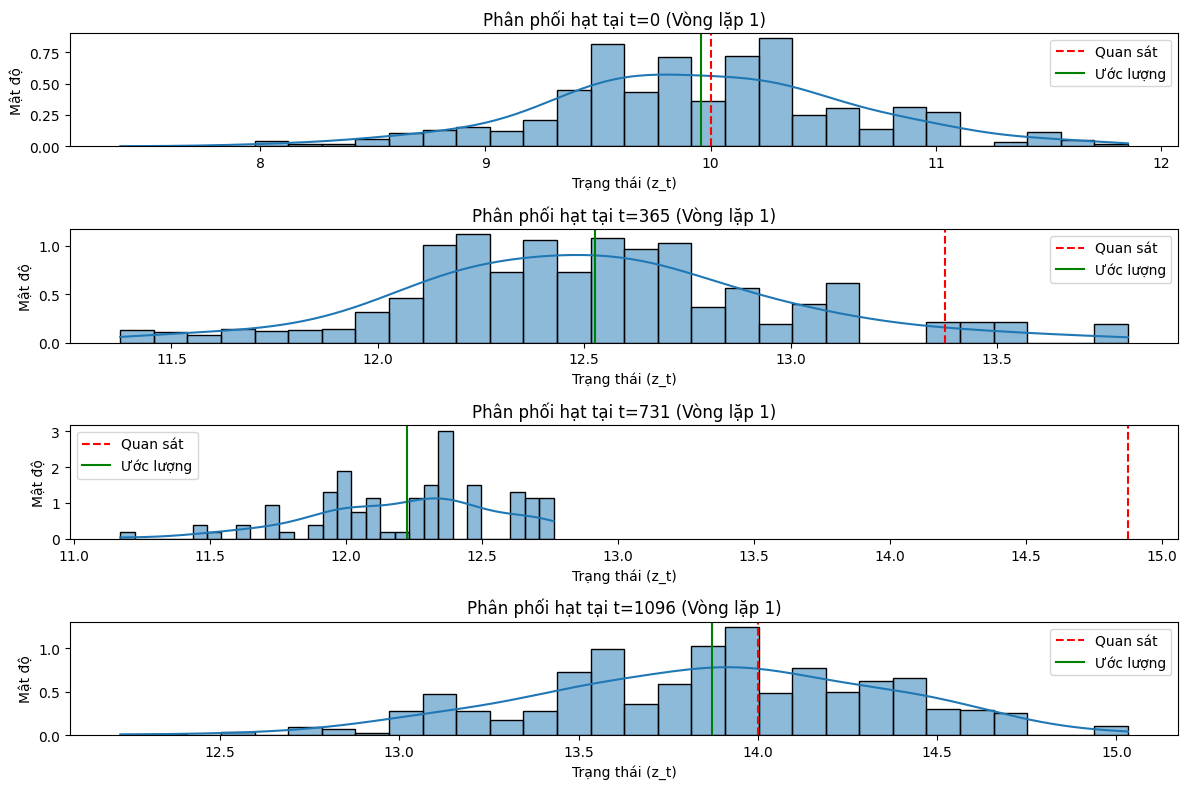

A: 0.9990, C: 1.0441, Q: 1.3347, R: 2.5448, mu_0: 9.9581, Sigma_0: 0.4391
Vòng lặp 2/10
A: 0.9979, C: 1.0434, Q: 2.8061, R: 0.7216, mu_0: 9.8233, Sigma_0: 0.3821
Vòng lặp 3/10
A: 0.9974, C: 1.0431, Q: 3.4020, R: 0.1320, mu_0: 9.7976, Sigma_0: 0.2249
Vòng lặp 4/10
A: 0.9981, C: 1.0427, Q: 2.4497, R: 0.0556, mu_0: 9.6992, Sigma_0: 0.0722
Vòng lặp 5/10
A: 0.9982, C: 1.0422, Q: 2.3210, R: 0.0584, mu_0: 9.6137, Sigma_0: 0.0314
Vòng lặp 6/10
A: 0.9983, C: 1.0417, Q: 2.2513, R: 0.0691, mu_0: 9.6052, Sigma_0: 0.0169
Vòng lặp 7/10
A: 0.9983, C: 1.0410, Q: 2.2846, R: 0.0639, mu_0: 9.6158, Sigma_0: 0.0136
Vòng lặp 8/10
A: 0.9983, C: 1.0406, Q: 2.2718, R: 0.0732, mu_0: 9.6192, Sigma_0: 0.0092
Vòng lặp 9/10
A: 0.9983, C: 1.0402, Q: 2.2728, R: 0.1005, mu_0: 9.6167, Sigma_0: 0.0085
Vòng lặp 10/10


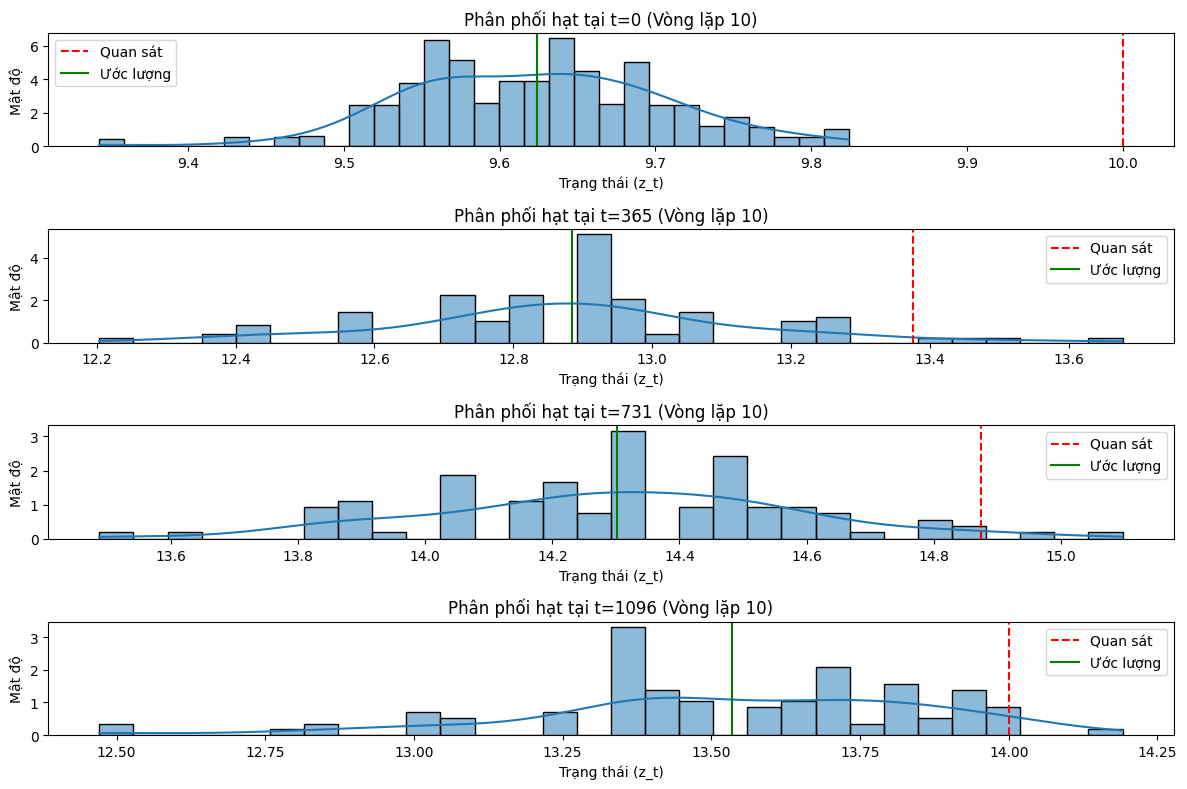

A: 0.9983, C: 1.0393, Q: 2.2639, R: 0.0901, mu_0: 9.6240, Sigma_0: 0.0066


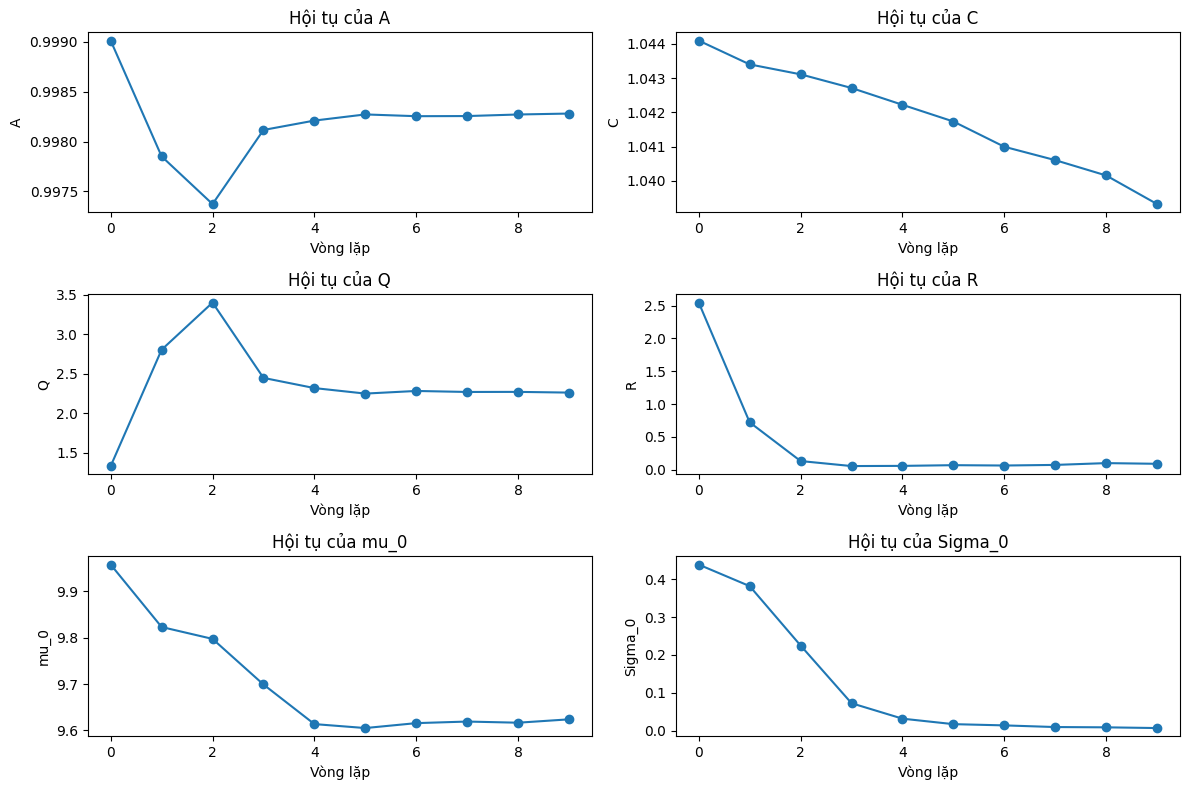

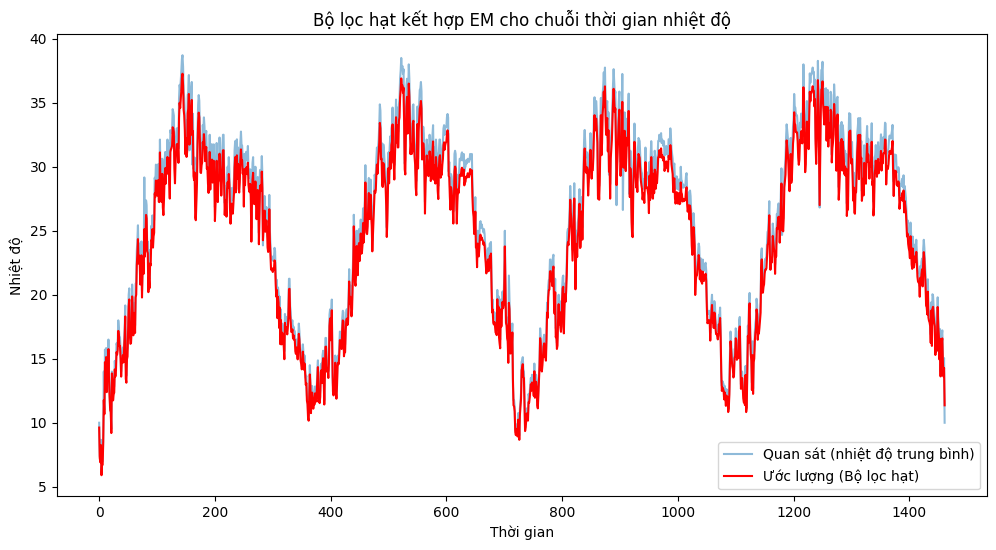

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
du_lieu_train = pd.read_csv('/content/DailyDelhiClimateTrain.csv')
du_lieu = du_lieu_train['meantemp'].values  # Chỉ lấy cột nhiệt độ trung bình

# Khởi tạo tham số mô hình
np.random.seed(42)
A = 0.99  # Ma trận chuyển trạng thái
C = 1.0   # Ma trận quan sát
Q = 0.1   # Hiệp phương sai nhiễu trạng thái
R = 1.0   # Hiệp phương sai nhiễu quan sát
mu_0 = du_lieu[0]  # Trạng thái ban đầu
Sigma_0 = 1.0      # Hiệp phương sai ban đầu
so_hat = 100       # Số lượng hạt
so_vong_lap = 10   # Số lần lặp EM

# Lưu lịch sử tham số để vẽ đồ thị
lich_su_tham_so = {
    'A': [], 'C': [], 'Q': [], 'R': [], 'mu_0': [], 'Sigma_0': []
}

# Hàm bộ lọc hạt
def bo_loc_hat(du_lieu, A, C, Q, R, mu_0, Sigma_0, so_hat):
    T = len(du_lieu)
    hat = np.zeros((T, so_hat))      # Trạng thái các hạt
    trong_so = np.zeros((T, so_hat)) # Trọng số
    uoc_luong = np.zeros(T)          # Ước lượng trạng thái

    # Khởi tạo hạt ban đầu
    hat[0, :] = np.random.normal(mu_0, np.sqrt(Sigma_0), so_hat)
    trong_so[0, :] = 1.0 / so_hat

    for t in range(T):
        if t > 0:
            hat[t, :] = A * hat[t - 1, :] + np.random.normal(0, np.sqrt(Q), so_hat)
        else:
            hat[t, :] = hat[0, :]

        # Tính xác suất quan sát
        kha_nang = np.exp(-0.5 * (du_lieu[t] - C * hat[t, :])**2 / R) / np.sqrt(2 * np.pi * R)
        trong_so[t, :] = kha_nang if t == 0 else trong_so[t - 1, :] * kha_nang
        tong_trong_so = np.sum(trong_so[t, :])
        if tong_trong_so > 0:
            trong_so[t, :] /= tong_trong_so
        else:
            trong_so[t, :] = 1.0 / so_hat

        # Ước lượng
        uoc_luong[t] = np.sum(hat[t, :] * trong_so[t, :])

        # Tái lấy mẫu nếu cần
        kich_thuoc_hieu_dung = 1.0 / np.sum(trong_so[t, :]**2)
        if kich_thuoc_hieu_dung < so_hat / 2:
            chi_so = np.random.choice(so_hat, size=so_hat, p=trong_so[t, :])
            hat[t, :] = hat[t, chi_so]
            trong_so[t, :] = 1.0 / so_hat

    return hat, trong_so, uoc_luong

# Vẽ phân phối hạt tại một số thời điểm
def ve_phan_phoi_hat(hat, trong_so, du_lieu, thoi_diem, vong_lap):
    plt.figure(figsize=(12, 8))
    for i, t in enumerate(thoi_diem):
        plt.subplot(len(thoi_diem), 1, i + 1)
        sns.histplot(x=hat[t, :], weights=trong_so[t, :], bins=30, kde=True, stat='density')
        plt.axvline(du_lieu[t], color='red', linestyle='--', label='Quan sát')
        plt.axvline(np.sum(hat[t, :] * trong_so[t, :]), color='green', linestyle='-', label='Ước lượng')
        plt.title(f'Phân phối hạt tại t={t} (Vòng lặp {vong_lap + 1})')
        plt.xlabel('Trạng thái (z_t)')
        plt.ylabel('Mật độ')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Vẽ sự hội tụ tham số
def ve_hoi_tu_tham_so(lich_su_tham_so):
    plt.figure(figsize=(12, 8))
    cac_tham_so = ['A', 'C', 'Q', 'R', 'mu_0', 'Sigma_0']
    for i, ten in enumerate(cac_tham_so):
        plt.subplot(3, 2, i + 1)
        plt.plot(lich_su_tham_so[ten], marker='o')
        plt.title(f'Hội tụ của {ten}')
        plt.xlabel('Vòng lặp')
        plt.ylabel(ten)
    plt.tight_layout()
    plt.show()

# Thuật toán EM
def thuat_toan_em(du_lieu, A, C, Q, R, mu_0, Sigma_0, so_hat, so_vong_lap):
    T = len(du_lieu)
    thoi_diem_ve = [0, T // 4, T // 2, 3 * T // 4]

    for vong_lap in range(so_vong_lap):
        print(f"Vòng lặp {vong_lap + 1}/{so_vong_lap}")

        # E-step
        hat, trong_so, uoc_luong = bo_loc_hat(du_lieu, A, C, Q, R, mu_0, Sigma_0, so_hat)

        if vong_lap == 0 or vong_lap == so_vong_lap - 1:
            ve_phan_phoi_hat(hat, trong_so, du_lieu, thoi_diem_ve, vong_lap)

        # Kỳ vọng
        Ez = np.zeros(T)
        Ezz = np.zeros(T)
        Ez1z = np.zeros(T - 1)

        for t in range(T):
            Ez[t] = np.sum(hat[t, :] * trong_so[t, :])
            Ezz[t] = np.sum(hat[t, :]**2 * trong_so[t, :])
            if t < T - 1:
                Ez1z[t] = np.sum(hat[t + 1, :] * hat[t, :] * trong_so[t + 1, :])

        # M-step
        mu_0_moi = Ez[0]
        Sigma_0_moi = Ezz[0] - Ez[0]**2

        tong_Ez1z = np.sum(Ez1z)
        tong_Ezz = np.sum(Ezz[:-1])
        A_moi = tong_Ez1z / tong_Ezz if tong_Ezz != 0 else A

        Q_moi = (1 / (T - 1)) * np.sum(Ezz[1:] - 2 * A_moi * Ez1z + A_moi**2 * Ezz[:-1])
        Q_moi = max(Q_moi, 1e-6)

        tong_xEz = np.sum(du_lieu * Ez)
        tong_Ezz_all = np.sum(Ezz)
        C_moi = tong_xEz / tong_Ezz_all if tong_Ezz_all != 0 else C

        R_moi = (1 / T) * np.sum((du_lieu - C_moi * Ez)**2)
        R_moi = max(R_moi, 1e-6)

        # Lưu tham số
        lich_su_tham_so['A'].append(A_moi)
        lich_su_tham_so['C'].append(C_moi)
        lich_su_tham_so['Q'].append(Q_moi)
        lich_su_tham_so['R'].append(R_moi)
        lich_su_tham_so['mu_0'].append(mu_0_moi)
        lich_su_tham_so['Sigma_0'].append(Sigma_0_moi)

        # Cập nhật
        A, C, Q, R, mu_0, Sigma_0 = A_moi, C_moi, Q_moi, R_moi, mu_0_moi, Sigma_0_moi

        print(f"A: {A:.4f}, C: {C:.4f}, Q: {Q:.4f}, R: {R:.4f}, mu_0: {mu_0:.4f}, Sigma_0: {Sigma_0:.4f}")

    return A, C, Q, R, mu_0, Sigma_0, uoc_luong

# Chạy thuật toán EM
A, C, Q, R, mu_0, Sigma_0, uoc_luong = thuat_toan_em(
    du_lieu, A, C, Q, R, mu_0, Sigma_0, so_hat, so_vong_lap
)

# Vẽ hội tụ
ve_hoi_tu_tham_so(lich_su_tham_so)

# Vẽ kết quả cuối cùng
plt.figure(figsize=(12, 6))
plt.plot(du_lieu, label='Quan sát (nhiệt độ trung bình)', alpha=0.5)
plt.plot(uoc_luong, label='Ước lượng (Bộ lọc hạt)', color='red')
plt.legend()
plt.title('Bộ lọc hạt kết hợp EM cho chuỗi thời gian nhiệt độ')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ')
plt.show()
